# A note on dust torus thermal emission

`agnpy` is meant for calculations of non-thermal processes occurring in the jets of active galaxies. The dust torus (DT) emission is considered as a target radiation field for inverse Compton scattering or pair production.

The contribution of the thermal emission of the DT to the overall MWL SED is usually considered in Flat Spectrum Radio Quasars (FSRQs), where still, this component is typically dominated by synchrotron radiation (see Fig. 15 in [Aleksic et al. 2016](https://ui.adsabs.harvard.edu/abs/2014A%26A...569A..46A/abstract)). The function computing the DT thermal SED in `agnpy` is mostly meant to check that this emission does not overtake the synchrotron one, and **not for precise modelling of the DT emission**.

In this notebook we will illustrate that the single-temperature black-body (BB) radiation computed by `agnpy` (in `RingDustTorus.sed_flux`) does not accurately model the thermal emission observed from a DT. At the same time, we illustrate that for the sake of the inverse Compton calculation, even the strongest approximation of the emission as monochromatic (at the BB peak) is satisfactory.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
import pkg_resources

In [2]:
# import agnpy classes
from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label
load_mpl_rc()

## Using single- and multi-temperature black body to model the DT thermal emission

We will consider, in this example, the DT emission in NGC 1068, using measurement from [Rieke and Low, 1975](https://ui.adsabs.harvard.edu/abs/1975ApJ...199L..13R/abstract) and a dedicated model of the emission by [Pier and Krolik, 1993](https://ui.adsabs.harvard.edu/abs/1992ApJ...401...99P/abstract).

In [3]:
# load the Rieke and Low 1975 spectral points, they are included in the agnpy data
sed_file = pkg_resources.resource_filename("agnpy", "data/dt_seds/NGC1068_rieke_low_1975.txt")
sed_data = np.loadtxt(sed_file)

_lambda = sed_data[:, 0] * u.um
flux = sed_data[:, 1] * u.Jy
flux_err = sed_data[:, 2] * u.Jy

# get a nuFnu SED
nu = _lambda.to("Hz", equivalencies=u.spectral())
sed = (flux * nu).to("erg cm-2 s-1")
sed_err = (flux_err * nu).to("erg cm-2 s-1")

# flip the arrays (data were in wavelengths)
nu = np.flip(nu)
sed = np.flip(sed)
sed_err = np.flip(sed_err)

In [4]:
# load the Pier and Krolik 1992 model
model_file = pkg_resources.resource_filename("agnpy", "data/dt_seds/pier_krolik_1992.txt")
model_data = np.loadtxt(model_file)

_lambda_model = model_data[:, 0] * u.um
flux_model = model_data[:, 1] * u.Unit("Jy um-1")

# get a nuFnu SED
nu_model = _lambda_model.to("Hz", equivalencies=u.spectral())
sed_model = (flux_model * const.c).to("erg cm-2 s-1")

# flip the arrays (data were in wavelengths)
nu_model = np.flip(nu_model)
sed_model = np.flip(sed_model)

# create a function interpolating the model points
pier_krolik_sed_flux = interp1d(nu_model, sed_model)

Now that we have the measured flux and an accurate model, let us try to reproduce the DT emission with a single- and multi-temperature black body, using `agnpy`.

In [5]:
# single-temperature black body
# this is computed by default by agnpy's RingDustTorus.sed_flux
L_disk = 0.6 * 4.7e11 * const.L_sun
R_dt = 1 * u.pc
d_L = 22 * u.Mpc
T = 500 * u.K
z = Distance(d_L).z

dt_single = RingDustTorus(L_disk=L_disk, T_dt=T, xi_dt=1., R_dt=R_dt)

# recompute the SED on the same frequency of the Pier Krolik model
sed_single_t = dt_single.sed_flux(nu_model, z)

Given 20 wavelength values from $2$ to $30$ $\mu{\rm m}$, we will consider the same number of DT whose BB emission peaks at each $\lambda$ value. To generate the multi-temperature BB we will simply sum their emission. The total luminosity is the same of the single-temperature BB, additionally we scale each BB component following the Pier & Krolik 1993 model.

In [6]:
def get_T_from_nu_peak(lambdas):
    """for each peak wavelgength get the corresponding BB peak T
    using Wien's displacement law: lambda_peak = b / T"""
    b = 2898 * u.um * u.K
    T = b / lambdas
    return T.to("K")

# multi-T black body:
# let us consider a range of wavelengths and extract the corresponding T for the BB to peak there
number_bb = 20
lambdas = np.logspace(np.log10(3), np.log10(30), number_bb) * u.um
nu_bb = lambdas.to("Hz", equivalencies=u.spectral())

T = get_T_from_nu_peak(lambdas)

In [7]:
# to create a multi-T BB, we create a list of DTs with different T
dts = []
seds_multi_t = []

for _T, _nu in zip(T, nu_bb):
    # scale the luminosity of each BB following the Pier Krolik model
    L_scale_factor = pier_krolik_sed_flux(_nu) / np.sum(pier_krolik_sed_flux(nu_bb))
    dt = RingDustTorus(
        L_disk=L_scale_factor * L_disk, 
        T_dt=_T, 
        xi_dt=1., 
        R_dt=R_dt
    )
    dts.append(dt)
    seds_multi_t.append(dt.sed_flux(nu_model, z))

# compute their sum  
sed_multi_t = np.sum(np.asarray(seds_multi_t), axis=0)

Let us see how they compare to each other

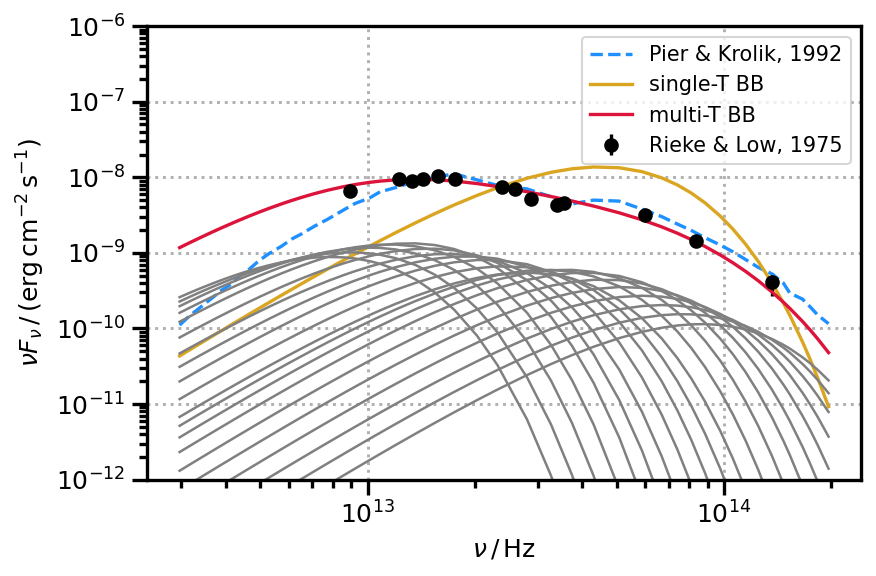

In [8]:
fig, ax = plt.subplots()
ax.loglog(nu_model, sed_model, ls="--", color="dodgerblue", label="Pier & Krolik, 1992")
ax.loglog(nu_model, sed_single_t, ls="-", color="goldenrod", label="single-T BB")
for i in range(len(seds_multi_t)):
    ax.loglog(nu_model, seds_multi_t[i], ls="-", lw=1.2, color="gray")
ax.loglog(nu_model, sed_multi_t, ls="-", color="crimson", label="multi-T BB")
ax.errorbar(nu.value, sed.value, yerr=sed_err.value, ls="", marker="o", color="k", label="Rieke & Low, 1975")

ax.legend(fontsize=10)
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-12, 1e-6])
plt.show()

It is clear that the single-temperature black body does not accurately reproduce the broad $(100-1\,{\rm \mu m})$ band observed flux. It does not span the entire range of data and it peaks in the wrong energy range. A multi-temperature black body is clearly better suited to reproduces the observed DT SED.

## Impact on external Compton scattering

Let us consider now the impact of using a single monochromatic approximation for the DT emission in the EC calculation by exploring the difference when using a multi-temperature (always monochormatic) DT as target. To realise the latter we just re-use the previously created list of DT peaking at different temperatures and compute the EC scattering on their photon fields.

In [9]:
# arbitrary emission region
norm = 1.5e5 * u.Unit("cm-3")
parameters1 = {
    "p1": 2.0,
    "p2": 3.9,
    "gamma_b": 300.,
    "gamma_min": 2.5,
    "gamma_max": 3.e4,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters1}
R_b = 1.e16 * u.cm
B = 1. * u.G
delta_D = 20
Gamma = 17
blob = Blob(R_b, z, delta_D, Gamma, B, norm, spectrum_dict)
blob.set_gamma_size(500)


# let us consider the emission region at a distance smaller than the DT radius
r = 0.3 * u.pc
ec = ExternalCompton(blob, dt_single, r)

# compute the SED from EC
nu_ec = np.logspace(15, 26, 100) * u.Hz
sed_ec_single_t = ec.sed_flux(nu_ec)

In [10]:
# re-calculate the SED considering each of the previously generated DT ()
seds_ec_multi_t = []

for dt in dts:
    ec = ExternalCompton(blob, dt, r)
    seds_ec_multi_t.append(ec.sed_flux(nu_ec))

ec_dt_seds_sum = np.sum(np.asarray(seds_ec_multi_t), axis=0)

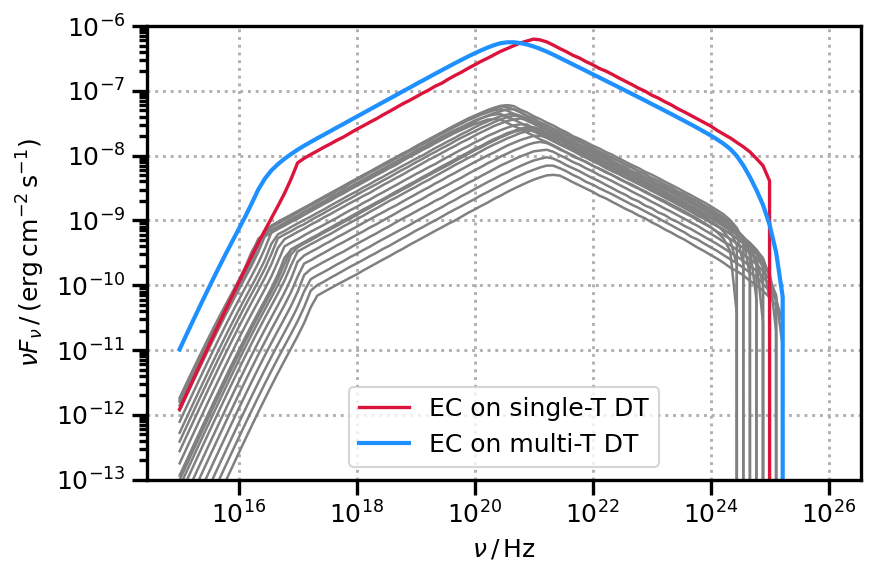

In [11]:
fig, ax = plt.subplots()


for i in range(len(seds_ec_multi_t)):
    ax.loglog(nu_ec, seds_ec_multi_t[i], ls="-", lw=1.2, color="gray")

ax.loglog(nu_ec, sed_ec_single_t, ls="-", color="crimson", label="EC on single-T DT")
ax.loglog(nu_ec, ec_dt_seds_sum, lw=2, ls="-", color="dodgerblue", label="EC on multi-T DT")    

ax.legend()
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-13, 1e-6])
plt.show()

As we can see, beside the low-energy branch of the SED, usually dominated by other radiative processes, considering a single- or multi-temperature DT target does not significantly impact the EC computation. The small shift of the two curves reflects the shift of the peak energy between the single delta function model and the full DT model.